In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import scipy.optimize
from sympy import diff,Symbol,lambdify

In [2]:
mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['xtick.labelsize'] = 'x-large'
#mpl.rcParams['xtick.major.size'] = 5 
#mpl.rcParams['xtick.major.width'] = 1.5 
mpl.rcParams['ytick.labelsize'] = 'x-large'
#mpl.rcParams['ytick.major.size'] = 5 
#mpl.rcParams['ytick.major.width'] = 1.5 
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['axes.grid']=True
mpl.rcParams['axes.titlesize']=20
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['legend.facecolor']='white'
mpl.rcParams['legend.fontsize']=18

folder='/home/patrick/Dropbox/School/phys344/Lab06/phys344lab06report'

In [3]:
rawcat={}
dtype_r=np.dtype({'names':['id','v.inst','dv.inst','b.inst','db.inst'],
               'formats':[np.int,np.float,np.float,np.float,np.float]})
rawdat=np.loadtxt('m34bv.raw',usecols=[0,3,4,5,6],unpack=True,skiprows=3,dtype=dtype_r)
rawcat['id']=rawdat[0]
rawcat['v.inst']=rawdat[1]
rawcat['dv.inst']=rawdat[2]
rawcat['b.inst']=rawdat[3]
rawcat['db.inst']=rawdat[4]
rawcat['b-v.inst']=rawcat['b.inst']-rawcat['v.inst']
rawcat['dbv.inst']=rawcat['dv.inst']+rawcat['db.inst']

dtype_sel=np.dtype({'names':['name','v.std','b.std','b-v.std'],
                'formats':['S20',np.float,np.float,np.float]})
selcat={}
seldat=np.loadtxt('stddat.csv',unpack=True,delimiter=',',skiprows=1,dtype=dtype_sel)   
selcat['name']=seldat[0]
selcat['v.std']=seldat[1]
selcat['b.std']=seldat[2]
selcat['b-v.std']=seldat[3]

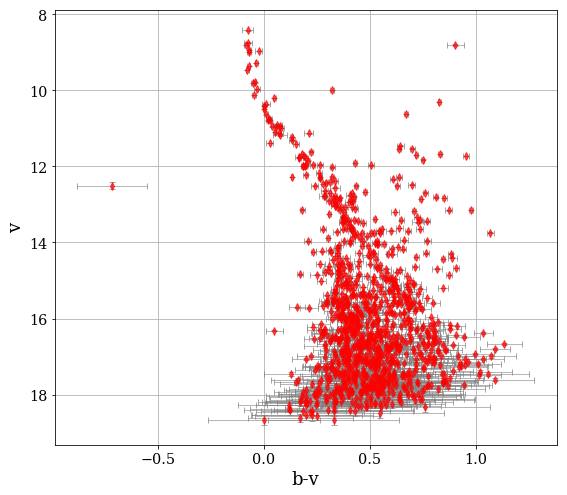

In [4]:
bv_inst=rawcat['b-v.inst']
v_inst=rawcat['v.inst']
dv_inst=rawcat['dv.inst']
dbv_inst=rawcat['dbv.inst']

fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
ax.errorbar(bv_inst,v_inst,dv_inst,dbv_inst,ms=5,capsize=3,elinewidth=0.8,ecolor='grey',
            fmt='rd',alpha=0.7)
ax.axes.invert_yaxis()
ax.set_xlabel('b-v')
ax.set_ylabel('v')
#ax.set_title('M34 instrumental (b-v, v) color-magnitude diagram')
filename='instmag.png'
path=folder+'/'+filename
fig.savefig(path)
plt.show()

In [5]:
def index(ids_c,ids_r): #find the index of each id_c in the ids_r array
    #'''
    if (type(ids_c) is np.ndarray) or isinstance(ids_c,list):
        il=[]
        for id_c in ids_c:
            #print id_c
            try:
                i=list(ids_r).index(id_c)
            except ValueError:
                i=np.nan
            il+=list([i])
        il=np.array(il).flatten()
        return il
    else:
        #print 'treating as int/flt'
        try:
            i=list(ids_r).index(ids_c)
        except ValueError:
            i=np.nan
        return i
def lookup(lookupval,lookuparray,targetarray):
    i=index(lookupval,lookuparray)
    return targetarray[i]

def dV(V):
    mi=min(selcat['v.std'])
    ma=max(selcat['v.std'])
    return 0.01*(3.-1.)/(ma-mi)*(V-mi)+0.01
def dBV(BV):
    mi=min(selcat['v.std'])
    ma=max(selcat['v.std'])
    return 0.005*(3.-1.)/(ma-mi)*(BV-mi)+0.005

def slopeline(x,m,b):
    return m*x+b

'''
print max(selcat['v.std'])
print min(selcat['v.std'])
print min(selcat['b-v.std'])
print max(selcat['b-v.std'])
'''
end=1

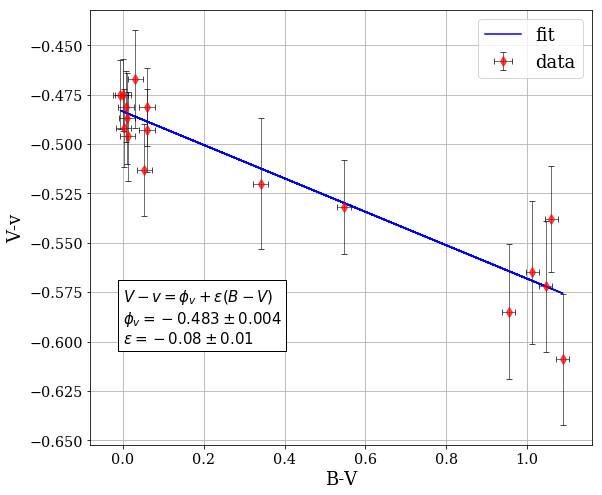

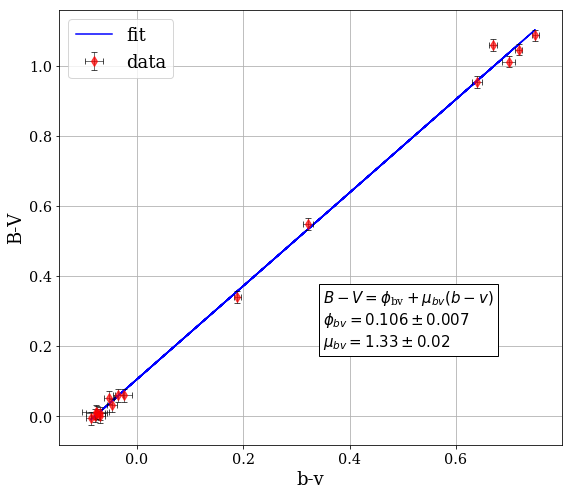

In [6]:
#dtype_c=np.dtype([('name','S8'),('raw.i',np.float)])
names_lkup,rawids_lkup=np.loadtxt('coords.csv',delimiter=',',
                                 usecols=[0,5],skiprows=1,
                                 dtype=np.dtype(np.str),
                                 unpack=True)
isna=rawids_lkup=='na'
rawids_lkup[isna]=np.nan
rawids_lkup=rawids_lkup.astype(np.int)
rawis_lkup=index(rawids_lkup,rawcat['id']) #indices (corresponding to the raw catalog) of the stars in the lookup table

selcat['raw.i']=np.array([rawis_lkup[i] for i in index(selcat['name'],names_lkup)])
rawi_sel=selcat['raw.i']
selcat['v.inst']=rawcat['v.inst'][rawi_sel]
selcat['b.inst']=rawcat['b.inst'][rawi_sel]
selcat['dv.inst']=rawcat['dv.inst'][rawi_sel]
selcat['db.inst']=rawcat['db.inst'][rawi_sel]
selcat['dv.std']=np.repeat(0.01,len(selcat['v.std']))
selcat['dv.std']=dV(selcat['v.std'])
selcat['dbv.std']=dBV(selcat['b-v.std'])
selcat['dbv.inst']=rawcat['dbv.inst'][rawi_sel]

V_sel=selcat['v.std']
v_sel=selcat['v.inst']
B_sel=selcat['b.std']
b_sel=selcat['b.inst']
dVv_sel=selcat['dv.std']+selcat['dv.inst']
dBV_sel=selcat['dbv.std']
dbv_sel=selcat['db.inst']+selcat['dv.inst']

#print max(dBV_sel)

fit1,cov1=scipy.optimize.curve_fit(slopeline,B_sel-V_sel,V_sel-v_sel,
                                   sigma=dVv_sel)
eps,phiv=fit1
deps,dphiv=[np.sqrt(cov1[i][i]) for i in range(fit1.size)]

fit2,cov2=scipy.optimize.curve_fit(slopeline,b_sel-v_sel,B_sel-V_sel,
                                  sigma=dBV_sel)
mu,phi_bv=fit2
dmu,dphi_bv=[np.sqrt(cov2[i][i]) for i in range(fit2.size)]

###################################################################
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
ax.plot(B_sel-V_sel,slopeline(B_sel-V_sel,eps,phiv),'b-',
        label='fit')
ax.errorbar(B_sel-V_sel,V_sel-v_sel,dVv_sel,dBV_sel,ms=7,capsize=3,
            elinewidth=0.8,ecolor='k',
            fmt='rd',alpha=0.7,label='data')
#ax.axes.invert_yaxis()
ax.set_xlabel('B-V')
ax.set_ylabel('V-v')
#ax.set_ylim(-0.7,-0.4)
#ax.set_title('M34 instrumental (b-v, v) color-magnitude diagram')
bbox_props=dict(boxstyle='square',fc='white') #Define properties of text box
plt.annotate('$V-v=\phi_v+\epsilon(B-V)$'
             '\n$\phi_v={0:0.3f}\pm{2:0.3f}$'
             '\n$\epsilon={1:0.2f}\pm{3:0.2f}$'.format(phiv,eps,
                                                       dphiv,deps),
             (0,-0.6),fontsize=15,bbox=bbox_props)
ax.legend()
filename='Vv.png'
path=folder+'/'+filename
fig.savefig(path)
plt.show()
###################################################################
###################################################################
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
ax.plot(b_sel-v_sel,slopeline(b_sel-v_sel,mu,phi_bv),'b-',
        label='fit')
ax.errorbar(b_sel-v_sel,B_sel-V_sel,dBV_sel,dbv_sel,ms=7,capsize=3,
            elinewidth=0.8,ecolor='k',
            fmt='rd',alpha=0.7,label='data')
#ax.axes.invert_yaxis()
ax.set_xlabel('b-v')
ax.set_ylabel('B-V')
#ax.set_title('M34 instrumental (b-v, v) color-magnitude diagram')
ax.legend()
filename='BV.png'
path=folder+'/'+filename
fig.savefig(path)
plt.annotate('$B-V=\phi_\mathregular{{bv}}+\mu_{{bv}}(b-v)$'
             '\n$\phi_{{bv}}={0:0.3f}\pm{2:0.3f}$'
             '\n$\mu_{{bv}}={1:0.2f}\pm{3:0.2f}$'.format(phi_bv,mu,
                                                       dphi_bv,
                                                       dmu),
             (0.35,0.2),fontsize=15,bbox=bbox_props)
plt.show()
###################################################################

In [7]:
def dBVf(b,v,db,dv):
    phi_bv_sym=Symbol('phi_bv')
    mu_sym=Symbol('mu')
    b_sym=Symbol('b')
    v_sym=Symbol('v')
    
    BV=phi_bv_sym+mu_sym*(b_sym-v_sym)
    #print BV
    #print (dphi_bv**2.+(BV.diff(b)*db)**2.)**(1./2.)
    dBVsym=(dphi_bv**2.
          +(BV.diff(mu_sym)*dmu)**2.
          +(BV.diff(b_sym)*db)**2.
          +(BV.diff(v_sym)*dv)**2.
          )**(1./2.)
    #print dBVsym
    #print dBVsym.evalf(subs={mu_sym:10})
    dBVf=lambdify(((mu_sym,b_sym,v_sym),),dBVsym)
    return dBVf((mu,b,v))
def stdV(BV,v):
    V=phiv+eps*(BV)+v
    dV=np.sqrt(dphiv**2.+(V.diff(BV)*dBV)**2.+V.diff(epsilon)*deps**2.+dv**2.)
    return V,dV
def stdBV(b,v,db,dv):
    BV=phi_bv+mu*(b-v)
    dBv=dBVf(b,v,db,dv)
    return BV, dBV
def stdBV(bs,vs,dbs,dvs):
    BV=[]
    dBV=[]
    for b,v,db,dv in zip(bs,vs,dbs,dvs):
        #print type(b)
        #print type(v)
        BV_add=phi_bv+mu*(b-v)
        dBV_add=dBVf(b,v,db,dv)
        BV+=list([BV_add])
        dBV+=list([dBV_add])
    BV=np.array(BV).flatten()
    dBV=np.array(dBV).flatten()
    print BV
    print dBV
    print''
    return BV,dBV

rawisel=np.where([rawi in selcat['raw.i']
                  for rawi 
                  in np.arange(len(rawcat['id']))])[0].flatten()
rawi_nsel=np.where([not rawi in selcat['raw.i']
                   for rawi
                   in np.arange(len(rawcat['id']))])[0].flatten()
rawcat['V']=np.nan*np.ones(len(rawcat['id']))
rawcat['dV']=rawcat['V']
rawcat['B-V']=rawcat['V']
rawcat["dBV"]=rawcat['V']
#fill rawcat with the given std values for select stars:
#print rawcat['V'][rawisel]
rawcat['V'][rawisel]=selcat['v.std']
#print rawcat['V'][rawisel]
rawcat['dV'][rawisel]=selcat['dv.std']
rawcat['B-V'][rawisel]=selcat['b-v.std']
rawcat['dBV'][rawisel]=selcat['dbv.std']

In [8]:
#fill rawcat with calculated std values for non-select stars:
stdBVout=stdBV(rawcat['b.inst'][rawi_nsel],rawcat['v.inst'][rawi_nsel],
               rawcat['db.inst'][rawi_nsel],rawcat['dv.inst'][rawi_nsel])

[ 0.59726749  0.49069781  0.62923839 ...  0.75578989  0.48004085
 -0.84941589]
[0.06790238 0.09709411 0.02675732 ... 0.02513074 0.05642218 0.1574274 ]



In [9]:
print rawcat['B-V'][rawi_nsel]
rawcat['B-V'][rawi_nsel]=stdBVout[0]
print rawcat['B-V'][rawi_nsel]
print rawcat['dBV'][rawi_nsel]
rawcat['dBV'][rawi_nsel]=stdBVout[1]
print rawcat['dBV'][rawi_nsel]

[nan nan nan ... nan nan nan]
[ 0.59726749  0.49069781  0.62923839 ...  0.75578989  0.48004085
 -0.84941589]
[ 0.59726749  0.49069781  0.62923839 ...  0.75578989  0.48004085
 -0.84941589]
[0.06790238 0.09709411 0.02675732 ... 0.02513074 0.05642218 0.1574274 ]


In [10]:
print rawi_nsel.shape
print rawcat['B-V'].shape
print rawcat['dBV'][rawi_nsel].shape
print rawcat['B-V'][rawi_nsel]
print type(stdBVout[0])

(1048,)
(1065,)
(1048,)
[0.06790238 0.09709411 0.02675732 ... 0.02513074 0.05642218 0.1574274 ]
<type 'numpy.ndarray'>


In [11]:
print type(rawcat)
print rawcat.keys()
print rawcat['B-V']
rawcat['dBV'][0]=0
print rawcat['B-V']

<type 'dict'>
['db.inst', 'v.inst', 'V', 'b-v.inst', 'B-V', 'dv.inst', 'dV', 'dbv.inst', 'id', 'b.inst', 'dBV']
[0.06790238 0.09709411 0.02675732 ... 0.02513074 0.05642218 0.1574274 ]
[0.         0.09709411 0.02675732 ... 0.02513074 0.05642218 0.1574274 ]
